# Beta-beta Plots AFR/AAC Meta-GWAS
- **Project:** GP2 AFR-AAC meta-GWAS 
- **Version:** Python/3.9
- **Status:** COMPLETE
- **Started:** 22-FEB-2023
- **Last Updated:** 22-FEB-2023
    - **Update Description:**  Notebook started

## Notebook Overview
- Compare beta-beta of 35 hits identified in AFR-AA joint meta-GWAS to GP2 European
- Compare beta-beta of 90 EUR variants to AFR-AA joint meta-GWAS 

### CHANGELOG
- 22-FEB-2023: Notebook started 

---
# Data Overview 

| ANCESTRY |     DATASET     | CASES | CONTROLS |  TOTAL  |           ARRAY           |                NOTES                |
|:--------:|:---------------:|:-----:|:--------:|:-------------------------:|:---------------------------------------------------------------------------------------------------------------:|:-----------------------------------:|
|    AFR   | IPDGC – Nigeria |  304  |    285   |   589   |         NeuroChip         | . | 
|    AFR   |  GP2  |  711  |   1,011  |  1,722  |        NeuroBooster       | . |
|    AAC   |  GP2 |  185  |   1,149  |  1,334  |        NeuroBooster       | . | 
|    AAC   |     23andMe     |  288  |  193,985 | 194,273 | Omni Express & GSA & 550k |        Just summary statistics       |

# Getting Started


## Importing packages

In [23]:
## Import the necessary packages 
import os
import numpy as np
import pandas as pd
import math
import numbers
import sys
import subprocess
import statsmodels.api as sm
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

## Print out package versions
## Getting packages loaded into this notebook and their versions to allow for reproducibility
    # Repurposed code from stackoverflow here: https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook

## Import packages 
import pkg_resources
import types
from datetime import date
today = date.today()
date = today.strftime("%d-%b-%Y").upper()

## Define function 
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different imported names vs. system/pip names
        # Unfortunately, there is no systematic way to get pip names from a package's imported name. You'll have to add exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

## Get a list of packages imported 
imports = list(set(get_imports()))

# The only way I found to get the version of the root package from only the name of the package is to cross-check the names of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

## Print out packages and versions 
print(f"PACKAGE VERSIONS ({date})")
for r in requirements:
    print("\t{}=={}".format(*r))

PACKAGE VERSIONS (22-FEB-2023)
	matplotlib==3.5.2
	numpy==1.22.4
	scipy==1.8.1
	pandas==1.4.3
	statsmodels==0.13.2
	seaborn==0.11.2


In [34]:
## Read in the META5 hg38 betas (betas from all studies)
eur_betas = pd.read_csv(f"{WORK_DIR}/data/other/beta-beta/META5_EUR_BETA_hg38.csv")

## Read in metas 
aac_meta = pd.read_csv(f"{WORK_DIR}/data/AAC-META/AAC-ONLY-META-UpdatedforMETAL1.tbl", sep="\t")
afr_meta = pd.read_csv(f"{WORK_DIR}/data/AFR-META/AFR-ONLY-META-UpdatedforMETAL1.tbl", sep="\t")
combined_meta = pd.read_csv(f"{WORK_DIR}/data/AFR-AAC-META/AFR-AAC-META-UpdatedforMETAL1.tbl", sep="\t")

## Read in the 23andMe summary statistics
df_23andMe = pd.read_csv(f"{WORK_DIR}/data/23andMe/AAC_23andMe_MAF0.05.hg38.noindels.newMarkerIDs.tab", sep="\t")

## Read in chr1 EUR release 4 GWAS overlapping
chr1_eur_v4 = pd.read_csv(f"{WORK_DIR}/data/other/GP2_v4_EUR_chr1/GP2_v4_EUR_chr1_extractAACAFRhits-GWAS-MAF005-FEB20231.tbl", sep="\t")

In [25]:
%%bash

echo "Overlapping with META5 and AAC only meta-analysis"
grep -Fwf ${WORK_DIR}/data/other/beta-beta/META5_markerNames_hg38.txt ${WORK_DIR}/data/AAC-META/AAC-ONLY-META-UpdatedforMETAL1.tbl |wc -l
echo ""

echo "Overlapping with META5 and AFR only meta-analysis"
grep -Fwf ${WORK_DIR}/data/other/beta-beta/META5_markerNames_hg38.txt ${WORK_DIR}/data/AFR-META/AFR-ONLY-META-UpdatedforMETAL1.tbl | wc -l
echo ""

echo "Overlapping with META5 and joint AFR-AAC meta-analysis"
grep -Fwf ${WORK_DIR}/data/other/beta-beta/META5_markerNames_hg38.txt ${WORK_DIR}/data/AFR-AAC-META/AFR-AAC-META-UpdatedforMETAL1.tbl | wc -l

Overlapping with META5 and AAC only meta-analysis
77

Overlapping with META5 and AFR only meta-analysis
64

Overlapping with META5 and joint AFR-AAC meta-analysis
77


In [35]:
# Clean up META5 dataframe for merging 
rearrange_eur_betas = eur_betas[['MarkerName', 'EFFECT', 'BETA', 'NEAREST_GENE']].copy()
rearrange_eur_betas.columns = ['MarkerName', 'META5_EFFECT', 'META5_BETA', 'NEAREST_GENE']

## Clean up AAC meta dataframe for merging 
rearrange_aac_meta = aac_meta[['MarkerName', 'Allele1', 'Effect']].copy()
rearrange_aac_meta.columns = ['MarkerName', 'AAC_EFFECT', 'AAC_BETA']
rearrange_aac_meta['AAC_EFFECT'] = rearrange_aac_meta['AAC_EFFECT'].str.upper()

## Clean up AFR meta dataframe for merging
rearrange_afr_meta = afr_meta[['MarkerName', 'Allele1', 'Effect']].copy()
rearrange_afr_meta.columns = ['MarkerName', 'AFR_EFFECT', 'AFR_BETA']
rearrange_afr_meta['AFR_EFFECT'] = rearrange_afr_meta['AFR_EFFECT'].str.upper()

## Clean up joint AFR-AAC meta dataframe for merging
rearrange_combined_meta = combined_meta[['MarkerName', 'Allele1', 'Effect']].copy()
rearrange_combined_meta.columns = ['MarkerName', 'AFR_AAC_EFFECT', 'AFR_AAC_BETA']
rearrange_combined_meta['AFR_AAC_EFFECT'] = rearrange_combined_meta['AFR_AAC_EFFECT'].str.upper()

## Clean up chr1 EUR dataframe for merging
rearrange_chr1_eur_v4 = chr1_eur_v4[['MarkerName', 'Allele1', 'Effect']].copy()
rearrange_chr1_eur_v4.columns = ['MarkerName', 'EUR_EFFECT', 'EUR_BETA']
rearrange_chr1_eur_v4['EUR_EFFECT'] = rearrange_chr1_eur_v4['EUR_EFFECT'].str.upper()

In [36]:
rearrange_chr1_eur_v4

,MarkerName,EUR_EFFECT,EUR_BETA
0,chr1:155169734:A:G,A,-0.0107
1,chr1:155157915:G:A,A,-0.0372
2,chr1:155155273:T:C,T,0.0401
3,chr1:155165974:C:T,T,0.0090
4,chr1:155166081:A:G,A,-0.0093
5,chr1:155162930:G:A,A,0.0076
6,chr1:155165746:T:C,T,-0.0093
7,chr1:155167551:T:C,T,-0.0141
8,chr1:155162859:T:C,T,-0.0085
9,chr1:155167033:T:C,T,-0.0097


# META5 vs AAC

## Merge

In [28]:
## Merge 
eur_aac = pd.merge(rearrange_eur_betas, rearrange_aac_meta, on="MarkerName", how="inner")
eur_aac

,MarkerName,META5_EFFECT,META5_BETA,NEAREST_GENE,AAC_EFFECT,AAC_BETA
0,chr1:161499264:G:C,C,0.0650,FCGR2A,C,-0.0032
1,chr1:171750629:C:T,T,-0.0704,VAMP4,T,-0.0883
2,chr1:205754444:C:T,T,0.1066,NUCKS1,T,-0.0293
3,chr1:205768611:G:A,A,0.1315,RAB29,A,-0.3481
4,chr1:226728377:T:C,T,0.0833,ITPKB,T,-0.0286
...,...,...,...,...,...,...
72,chr18:33724354:G:T,T,0.0531,ASXL3,T,0.0813
73,chr18:43093415:A:G,A,-0.0983,RIT2,A,-0.0713
74,chr18:51157219:T:G,T,-0.0578,MEX3C,T,0.0029
75,chr19:2341049:C:T,T,-0.0696,SPPL2B,T,-0.0248


## Plot and Save

<module 'matplotlib.pyplot' from '/usr/local/Anaconda/envs/py3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

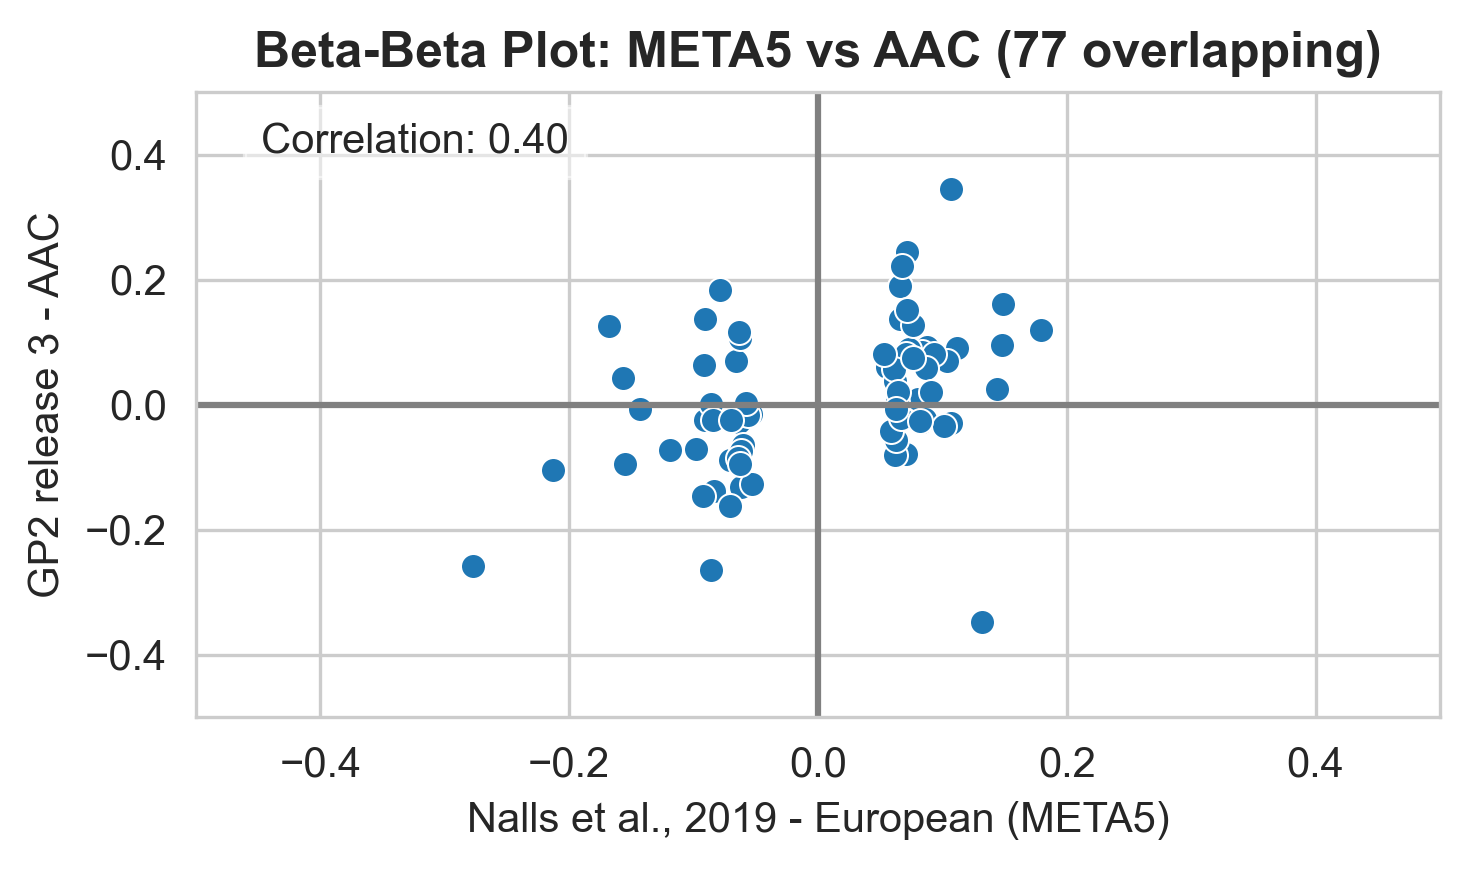

In [29]:
## beta-beta of EUR vs AAC 
sns.set_style("whitegrid")

plt.figure(figsize=(5, 3), dpi=300)

sns.scatterplot(x="META5_BETA", y="AAC_BETA", data=eur_aac) 
#                hue="EUR_DIR",
#                palette={"+": "#606AFF", "-": "#C2C2C2"}, alpha=0.8)
#plt.legend(title='Direction', loc='upper right')
plt.axvline(x=0, color="grey")
plt.axhline(y=0, color="grey")


plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.title("Beta-Beta Plot: META5 vs AAC (77 overlapping)", fontweight="bold")
plt.xlabel("Nalls et al., 2019 - European (META5)")
plt.ylabel("GP2 release 3 - AAC")


corr = eur_aac[["META5_BETA", "AAC_BETA"]].corr().iloc[0,1]

# Add box with correlation
plt.gca().text(0.3, 0.95, f"Correlation: {corr:.2f}", ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()

plt.savefig(f"{WORK_DIR}/data/other/beta-beta/META5_AAC_META_beta-beta.png")
#plt.close()
plt

# META5 vs AFR

## Merge 

In [30]:
## Merge 
eur_afc = pd.merge(rearrange_eur_betas, rearrange_afr_meta, on="MarkerName", how="inner")
eur_afc

,MarkerName,META5_EFFECT,META5_BETA,NEAREST_GENE,AFR_EFFECT,AFR_BETA
0,chr1:161499264:G:C,C,0.0650,FCGR2A,C,0.0623
1,chr1:171750629:C:T,T,-0.0704,VAMP4,T,0.1729
2,chr1:205754444:C:T,T,0.1066,NUCKS1,T,0.1807
3,chr1:226728377:T:C,T,0.0833,ITPKB,T,0.1283
4,chr1:232528865:C:T,T,0.1114,SIPA1L2,T,0.1010
...,...,...,...,...,...,...
59,chr18:33724354:G:T,T,0.0531,ASXL3,T,0.0513
60,chr18:43093415:A:G,A,-0.0983,RIT2,A,-0.1848
61,chr18:51157219:T:G,T,-0.0578,MEX3C,T,-0.1174
62,chr19:2341049:C:T,T,-0.0696,SPPL2B,T,-0.1139


## Plot and Save

<module 'matplotlib.pyplot' from '/usr/local/Anaconda/envs/py3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

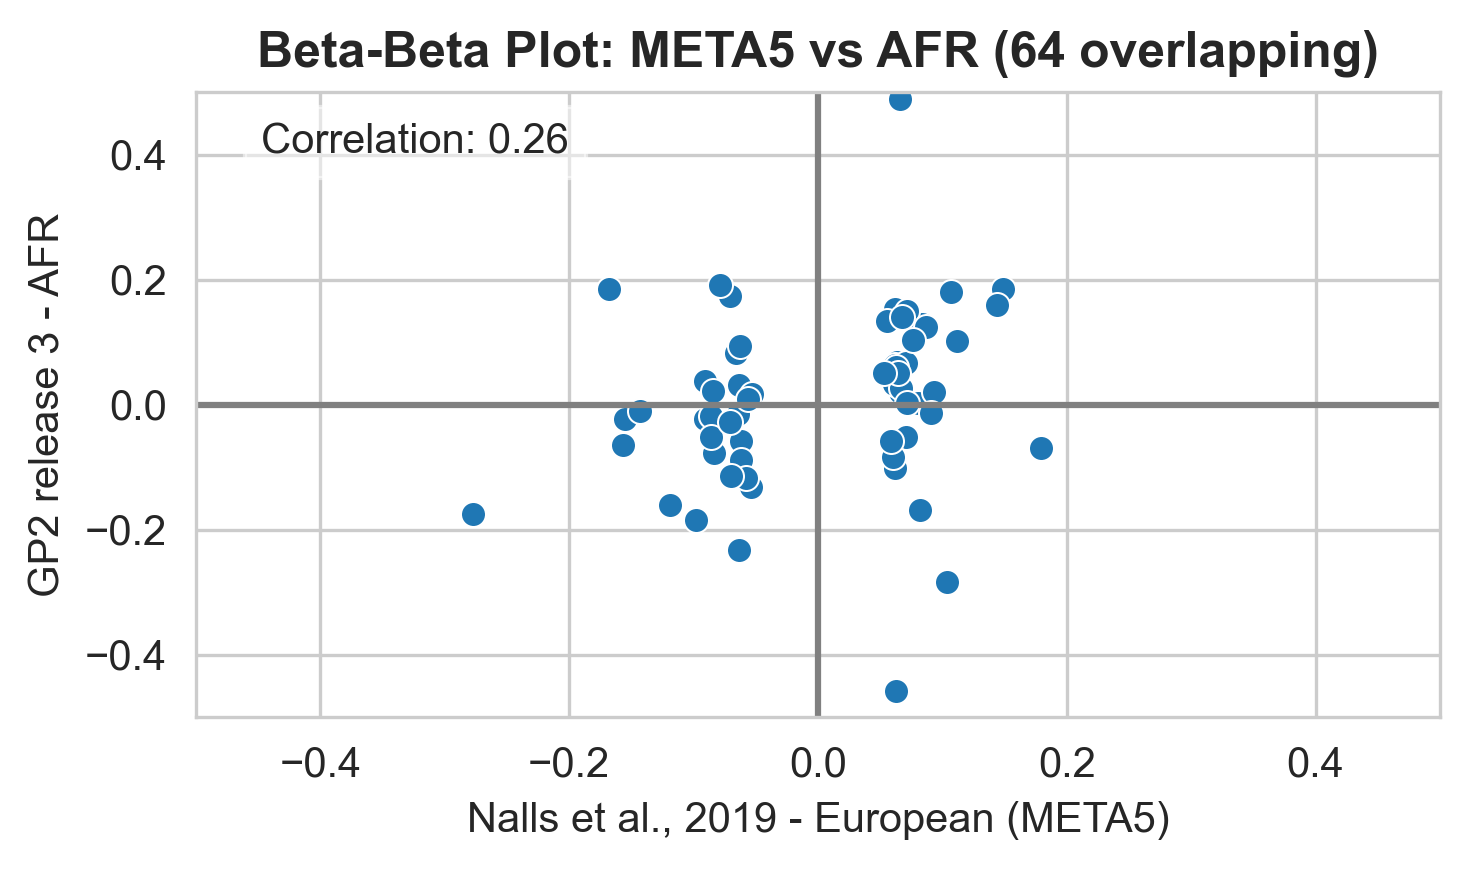

In [31]:
## beta-beta of EUR vs AAC 
sns.set_style("whitegrid")

plt.figure(figsize=(5, 3), dpi=300)

sns.scatterplot(x="META5_BETA", y="AFR_BETA", data=eur_afc) 
#                hue="EUR_DIR",
#                palette={"+": "#606AFF", "-": "#C2C2C2"}, alpha=0.8)
#plt.legend(title='Direction', loc='upper right')
plt.axvline(x=0, color="grey")
plt.axhline(y=0, color="grey")


plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.title("Beta-Beta Plot: META5 vs AFR (64 overlapping)", fontweight="bold")
plt.xlabel("Nalls et al., 2019 - European (META5)")
plt.ylabel("GP2 release 3 - AFR")

corr = eur_afc[["META5_BETA", "AFR_BETA"]].corr().iloc[0,1]

# Add box with correlation
plt.gca().text(0.3, 0.95, f"Correlation: {corr:.2f}", ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()

plt.savefig(f"{WORK_DIR}/data/other/beta-beta/META5_AFR_META_beta-beta.png")
#plt.close()
plt

# META5 vs AFR-AAC 

## Merge

In [32]:
## Merge 
eur_joint = pd.merge(rearrange_eur_betas, rearrange_combined_meta, on="MarkerName", how="inner")
eur_joint

,MarkerName,META5_EFFECT,META5_BETA,NEAREST_GENE,AFR_AAC_EFFECT,AFR_AAC_BETA
0,chr1:161499264:G:C,C,0.0650,FCGR2A,C,0.0298
1,chr1:171750629:C:T,T,-0.0704,VAMP4,T,0.0526
2,chr1:205754444:C:T,T,0.1066,NUCKS1,T,0.0723
3,chr1:205768611:G:A,A,0.1315,RAB29,A,-0.3481
4,chr1:226728377:T:C,T,0.0833,ITPKB,T,0.0493
...,...,...,...,...,...,...
72,chr18:33724354:G:T,T,0.0531,ASXL3,T,0.0675
73,chr18:43093415:A:G,A,-0.0983,RIT2,A,-0.1282
74,chr18:51157219:T:G,T,-0.0578,MEX3C,T,-0.0460
75,chr19:2341049:C:T,T,-0.0696,SPPL2B,T,-0.0648


## Plot and Save

<module 'matplotlib.pyplot' from '/usr/local/Anaconda/envs/py3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

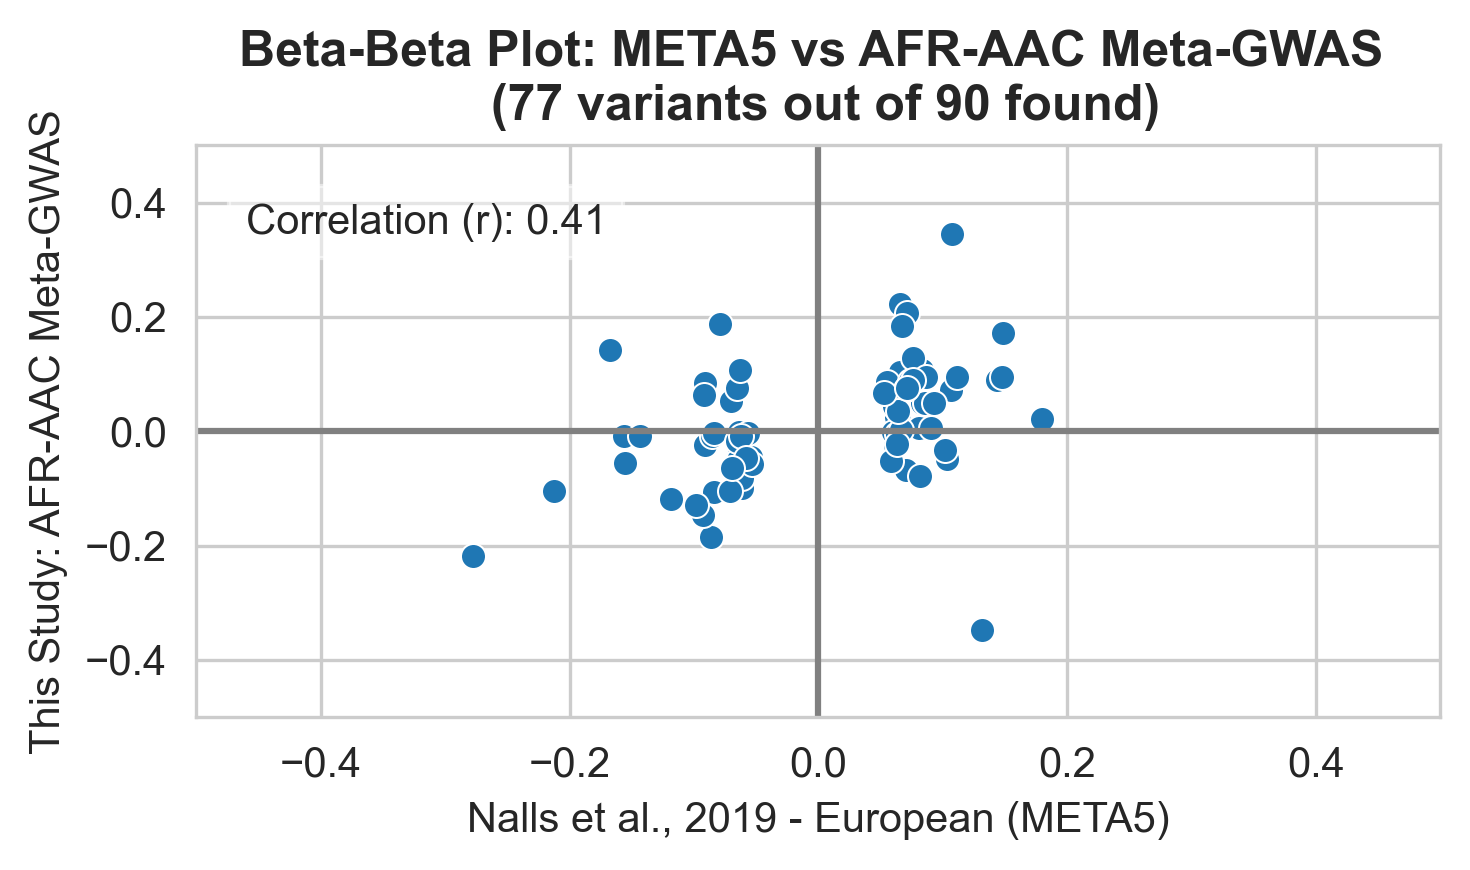

In [33]:
## beta-beta of EUR vs AAC 
sns.set_style("whitegrid")

plt.figure(figsize=(5, 3), dpi=300)

sns.scatterplot(x="META5_BETA", y="AFR_AAC_BETA", data=eur_joint) 
#                hue="EUR_DIR",
#                palette={"+": "#606AFF", "-": "#C2C2C2"}, alpha=0.8)
#plt.legend(title='Direction', loc='upper right')
plt.axvline(x=0, color="grey")
plt.axhline(y=0, color="grey")


plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)

plt.title("Beta-Beta Plot: META5 vs AFR-AAC Meta-GWAS \n (77 variants out of 90 found)", fontweight="bold")
plt.xlabel("Nalls et al., 2019 - European (META5)")
plt.ylabel("This Study: AFR-AAC Meta-GWAS")

corr = eur_joint[["META5_BETA", "AFR_AAC_BETA"]].corr().iloc[0,1]

# Add box with correlation
plt.gca().text(0.33, 0.9, f"Correlation (r): {corr:.2f}", ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()

plt.savefig(f"{WORK_DIR}/data/other/beta-beta/META5_AFR_AAC_META_beta-beta.png")
#plt.close()
plt

# Compare AFR-AAC Hits to chr1 EUR

## Merge

In [37]:
## Merge 
compare_eur_joint = pd.merge(rearrange_chr1_eur_v4, rearrange_combined_meta, on="MarkerName", how="inner")
compare_eur_joint

,MarkerName,EUR_EFFECT,EUR_BETA,AFR_AAC_EFFECT,AFR_AAC_BETA
0,chr1:155169734:A:G,A,-0.0107,A,0.2884
1,chr1:155157915:G:A,A,-0.0372,A,-0.2732
2,chr1:155155273:T:C,T,0.0401,T,0.2788
3,chr1:155165974:C:T,T,0.0090,T,-0.2908
4,chr1:155166081:A:G,A,-0.0093,A,0.2902
5,chr1:155162930:G:A,A,0.0076,A,-0.2878
6,chr1:155165746:T:C,T,-0.0093,T,0.2902
7,chr1:155167551:T:C,T,-0.0141,T,0.2868
8,chr1:155162859:T:C,T,-0.0085,T,0.2907
9,chr1:155167033:T:C,T,-0.0097,T,0.2900


## Plot and Save

<module 'matplotlib.pyplot' from '/usr/local/Anaconda/envs/py3.9/lib/python3.9/site-packages/matplotlib/pyplot.py'>

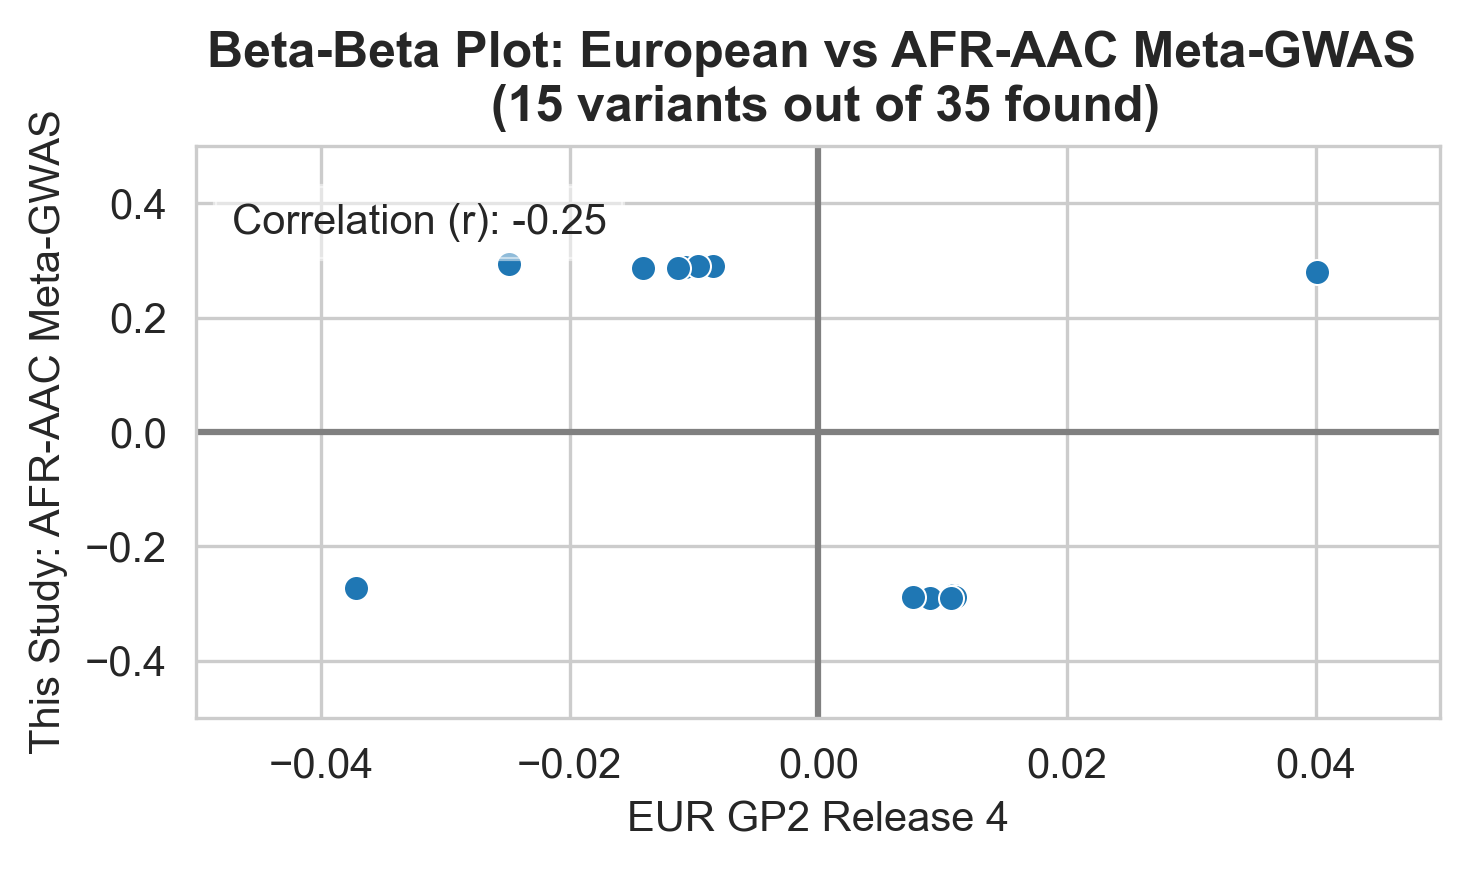

In [41]:
## beta-beta of EUR vs AAC 
sns.set_style("whitegrid")

plt.figure(figsize=(5, 3), dpi=300)

sns.scatterplot(x="EUR_BETA", y="AFR_AAC_BETA", data=compare_eur_joint) 
#                hue="EUR_DIR",
#                palette={"+": "#606AFF", "-": "#C2C2C2"}, alpha=0.8)
#plt.legend(title='Direction', loc='upper right')
plt.axvline(x=0, color="grey")
plt.axhline(y=0, color="grey")


plt.xlim(-0.05, 0.05)
plt.ylim(-0.5, 0.5)

plt.title("Beta-Beta Plot: European vs AFR-AAC Meta-GWAS \n (15 variants out of 35 found)", fontweight="bold")
plt.xlabel("EUR GP2 Release 4")
plt.ylabel("This Study: AFR-AAC Meta-GWAS")

corr = compare_eur_joint[["EUR_BETA", "AFR_AAC_BETA"]].corr().iloc[0,1]

# Add box with correlation
plt.gca().text(0.33, 0.9, f"Correlation (r): {corr:.2f}", ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()

plt.savefig(f"{WORK_DIR}/data/other/beta-beta/EUR_AFR_AAC_META_beta-beta.png")
#plt.close()
plt